In [73]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf
import torchvision
import torch.nn.functional as F
import logging

from matplotlib import pyplot as plt
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
from dataloader_fossilnet import FossilNET

In [79]:
# Set up model

# Define flows
L = 3
K = 16
torch.manual_seed(0)

input_shape = (3, 64, 64)
n_dims = np.prod(input_shape)
channels = 3
hidden_channels = 256
split_mode = 'channel'
scale = True
num_classes = 10

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i), 
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L, 
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.ClassCondDiagGaussian(latent_shape, num_classes)]


# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)

In [80]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [81]:
batch_size = 32

# From https://pytorch.org/hub/pytorch_vision_resnet/
imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        imagenet_normalize
])

# Get the training, validation and test data
training_data = FossilNET('dataset', 'train', transform=transform)
validation_data = FossilNET('dataset', 'val', transform=transform)
test_data = FossilNET('dataset', 'test', transform=transform)

# Put the training data into a train loader
train_loader = DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
train_iter = iter(train_loader)

In [90]:
20_000/(2000/32)

320.0

In [70]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([32, 3, 64, 64])

IndexError: index 32 is out of bounds for dimension 0 with size 32

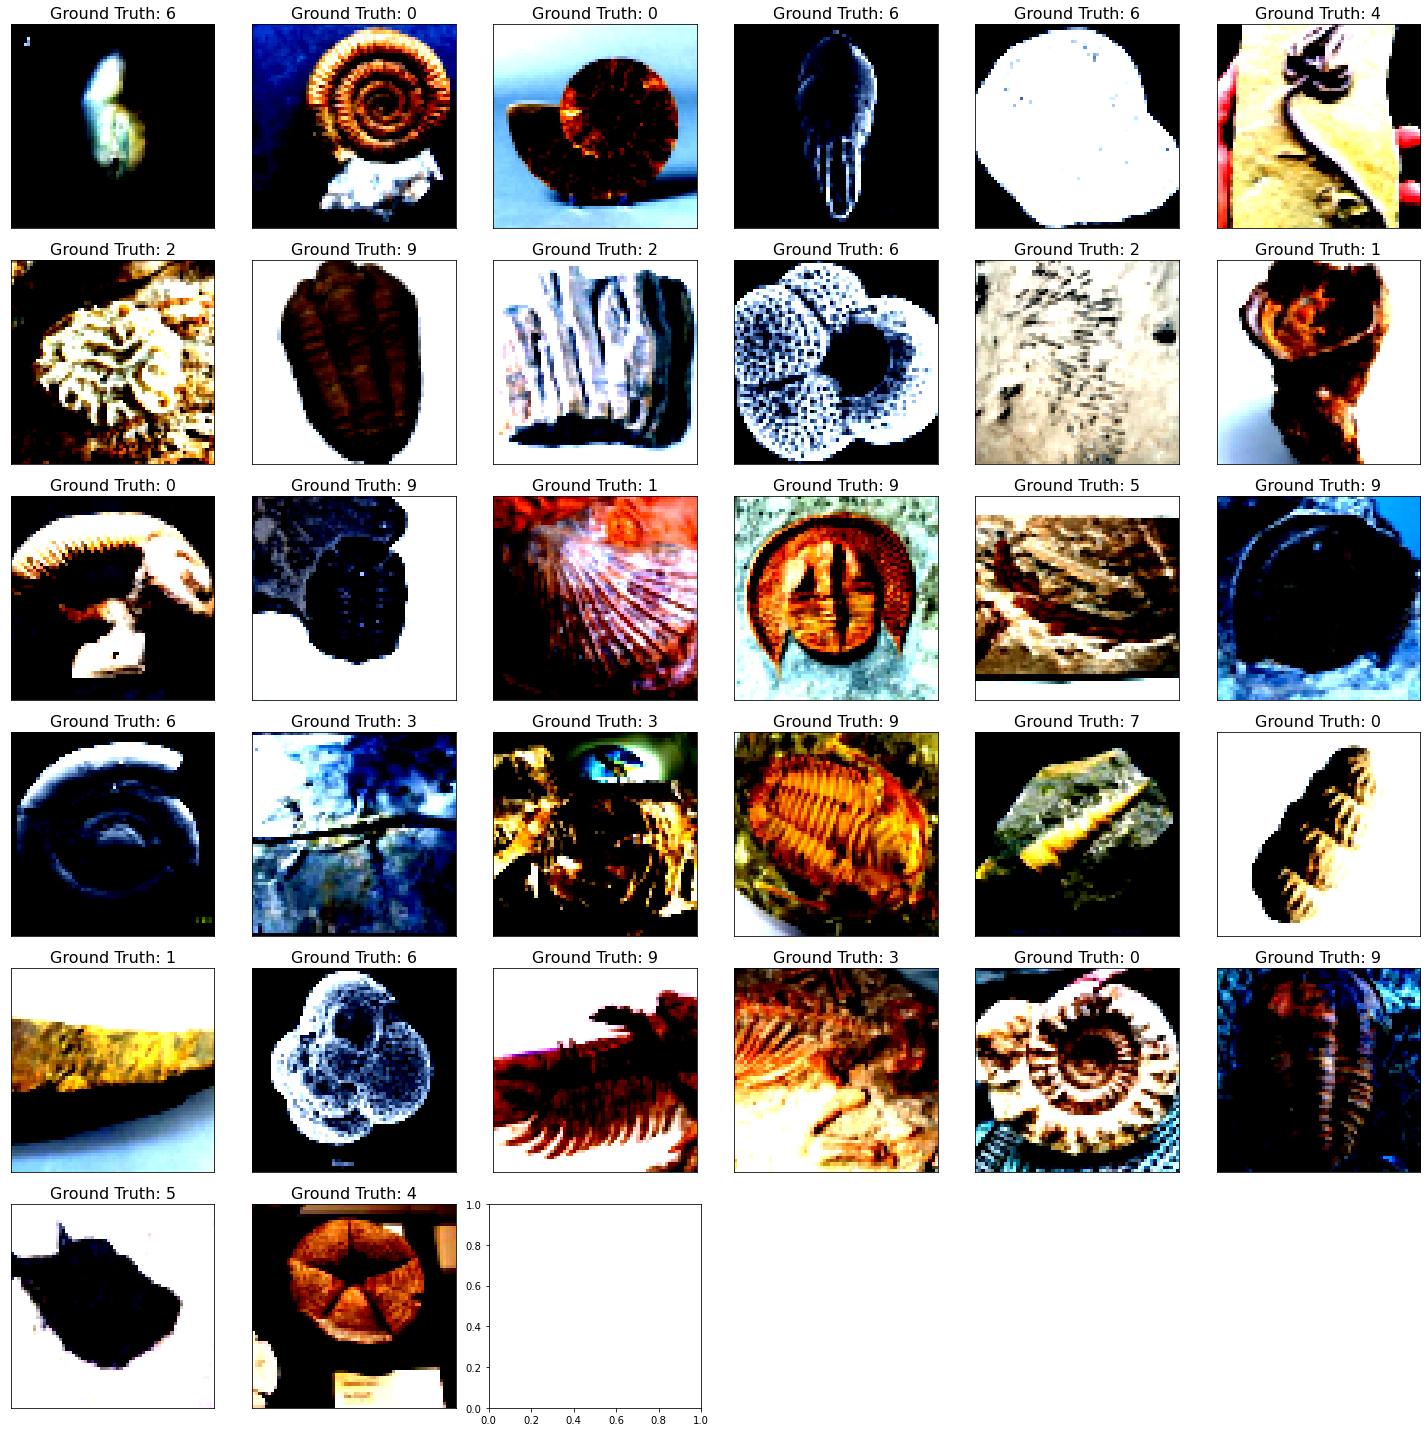

In [82]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

# There is some annoying warning regarding clipping because of the scaling of the data and this ignores is
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

fig = plt.figure(figsize=(20,20))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.tight_layout()
    plt.imshow((example_data[i].permute(1, 2, 0)), interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]), fontsize=16)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

logger.setLevel(old_level)

In [66]:
batch_size = 128

transform = tv.transforms.Compose([tv.transforms.ToTensor(), nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.)])
train_data = tv.datasets.CIFAR10('datasets/', train=True,
                                 download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                           drop_last=True)

test_data = tv.datasets.CIFAR10('datasets/', train=False,
                                download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

train_iter = iter(train_loader)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([128, 3, 32, 32])

In [83]:
# Train model
max_iter = 20000

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

for i in tqdm(range(max_iter)):
    try:
        x, y = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        x, y = next(train_iter)
    optimizer.zero_grad()
    loss = model.forward_kld(x.to(device), y.to(device))
        
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [1:19:20<00:00,  4.20it/s]


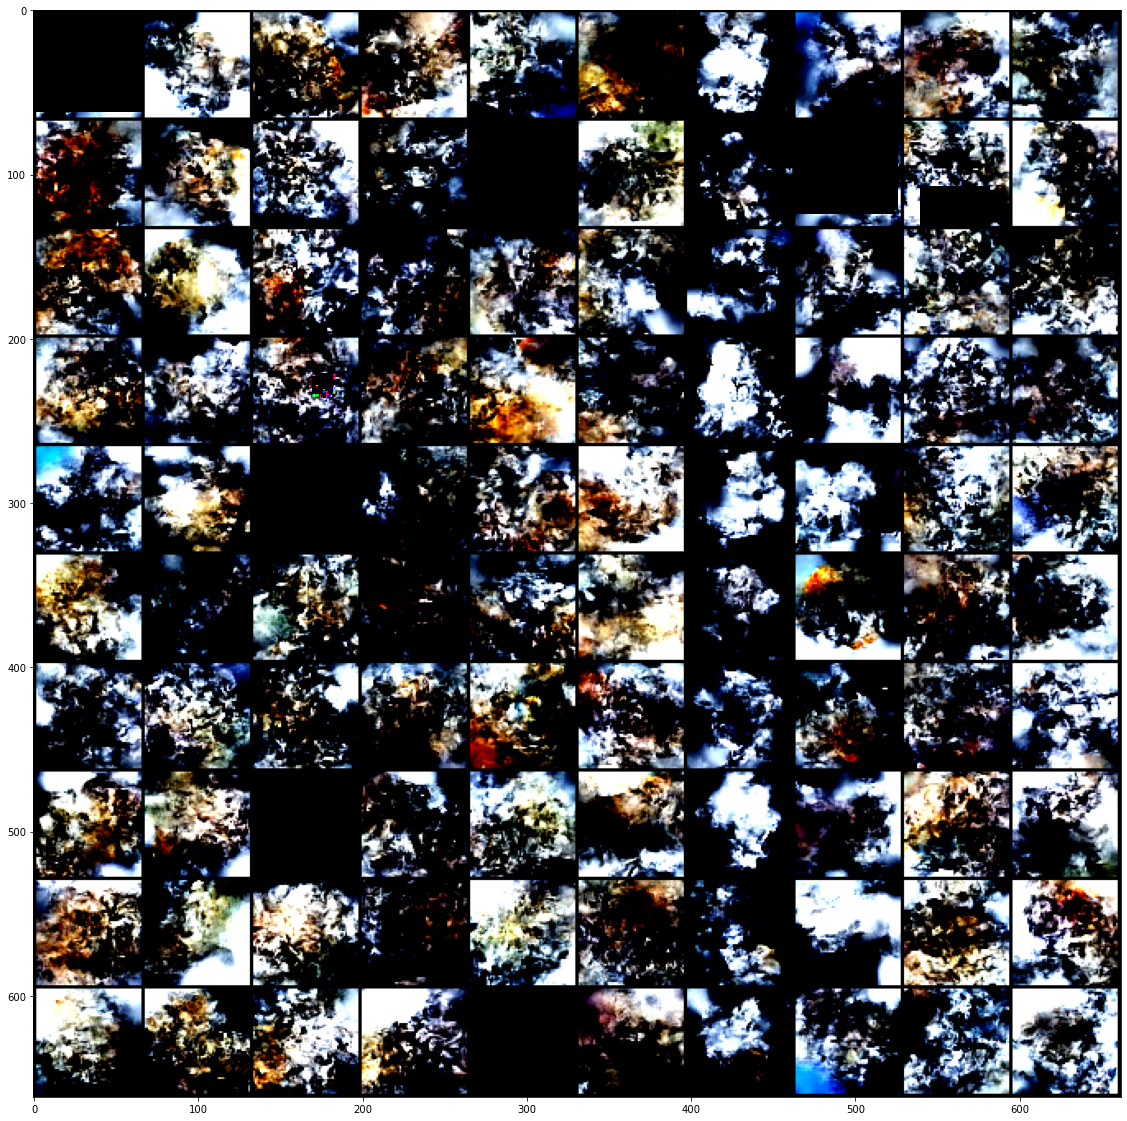

In [93]:
# Model samples
num_sample = 10

with torch.no_grad():
    y = torch.arange(num_classes).repeat(num_sample).to(device)
    x, _ = model.sample(y=y)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(tv.utils.make_grid(x_, nrow=num_classes).cpu().numpy(), (1, 2, 0)))
    plt.show()

In [92]:
y

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
        8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
        6, 7, 8, 9], device='cuda:0')

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

# There is some annoying warning regarding clipping because of the scaling of the data and this ignores is
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

fig = plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.tight_layout()
    plt.imshow((example_data[i].permute(1, 2, 0)), interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]), fontsize=16)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

logger.setLevel(old_level)

In [85]:
# Get bits per dim
n = 0
bpd_cum = 0
with torch.no_grad():
    for x, y in iter(test_loader):
        nll = model(x.to(device), y.to(device))
        nll_np = nll.cpu().numpy() 
        bpd_cum += np.nansum(nll_np / np.log(2) / n_dims + 8)
        n += len(x) - np.sum(np.isnan(nll_np))
        
    print('Bits per dim: ', bpd_cum / n)

Bits per dim:  5.62993913269043
